## Analysis of Non-Pros

This notebook uses the data set `rook_kyle.csv` which contains 1000 blitz games from each of bishop1021 and bindcommakyle. Dropping all games where neither player played white, we can perform binary classification methods.

A basic PCA transform demonstrates a clear differentiation in playstyle, particularly caught in the first principal component. We get $~85 \%$ from a logistic regression performed _just_ on the first principal component, while a logistic regression on all the variables brings that up to $92 \%$ accuracy.


In [26]:
## Imports
import functions as f
import numpy as np
import lichess.api
import pandas as pd
from importlib import reload
from sklearn.model_selection import train_test_split
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## Read in the data

df = pd.read_csv('rook_kyle.csv')

In [11]:
## Convert the data to white_player = other for players that aren't focused on
# This has been throwing a warning. If someone could look at it, and tell me if they know what's going on, I would appreciate it.
# (It still does the conversion correctly, so I haven't cared too much)
for i in range(len(df)):
    if (df['white_player'][i] != "rook1021") and (df['white_player'][i] != "bindercommakyle"):
        df['white_player'][i] = "other"

C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
## Make a dataframe with no "other", and one hot the player categorical variable.

no_other = df.loc[df['white_player'] != 'other']
one_zero_no_other = no_other.replace('bindercommakyle', 1).replace('rook1021', 0)

In [18]:
## Perform the train-test split

X = one_zero_no_other.drop(columns = ['white_player', 'game_id'])

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, one_zero_no_other['white_player'], test_size = 0.2, stratify = one_zero_no_other['white_player'])

In [21]:
## Scale the data by the training sample:

scaler = StandardScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test_unscaled)
X_train = scaler.transform(X_train_unscaled)

In [22]:
## A simple logistic regression model:

log_reg = LogisticRegression()
fit = log_reg.fit(X_train, y_train)

In [24]:
## Yields 92% accuracy!

sum(fit.predict(X_test) == y_test)/len(y_test)

0.9214659685863874

## PCA

We perform a PCA analysis on the data to visualize it, and it does give a good sense of some difference between the two players. That said, we run into the issue that running our classifiers on the PCA'd (with `n_components = 5`) data decreases the accuracy of the classifiers by $10\%$.

Since the classifiers that work can run rather quickly on the data set, the PCA only seems valuable in visualizing the data, and not in actually calculating predictions.

Also worth noting: the second principal component didn't actually seem to differentiate the data by player at all, so there is some sense in which the first principal component is the most important.

In [31]:
## We run the PCA
pca = PCA(n_components = 2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

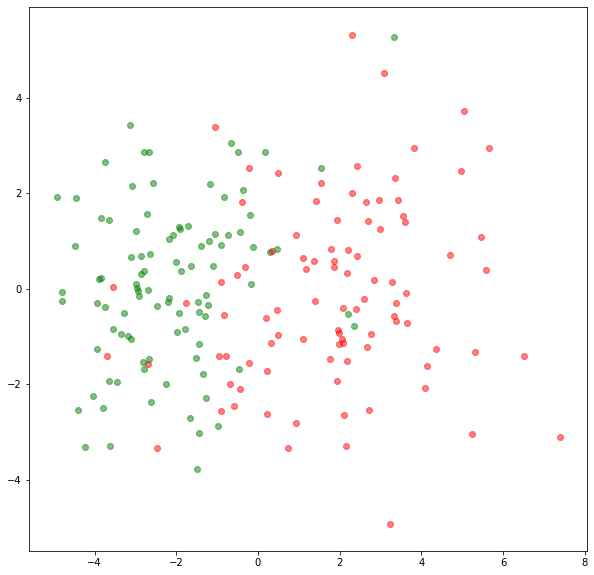

In [32]:
## Plotting the first two principal components
# We see that the first component captures most of the information that differentiates these players

plt.figure(figsize = (10,10))
def plot_by_white_player(X,y):
    for i in range(len(X)):
        if (y.iloc[i] == 1):
            color = 'red'
            plt.scatter(X[i][0], X[i][1], c = color, alpha = 0.5)
        elif (y.iloc[i] == 0):
            color = 'green'
            plt.scatter(X[i][0], X[i][1], c = color, alpha = 0.5)

plot_by_white_player(X_test_pca, y_test)
plt.show()

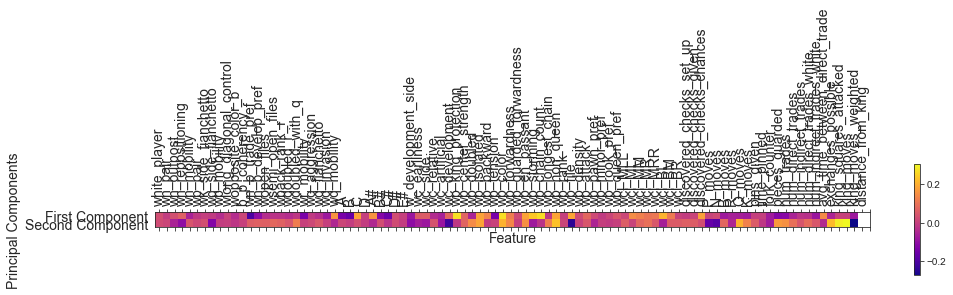

In [33]:
# We can visualize with a heatmap

sns.set_style("white")
plt.matshow(pca.components_, cmap = 'plasma')

plt.yticks([0,1], ["First Component", "Second Component"],
          fontsize = 14)

plt.colorbar()

plt.xticks(range(94),
          [df.columns[i] for i in range(1,94)], rotation = 90, 
          fontsize = 14)

plt.xlabel("Feature", fontsize = 14)
plt.ylabel("Principal Components", fontsize = 14)

plt.show()

In [34]:
## In spite of its predictive power, the PCA is still 'weak' in how much of the variance it predicts

pca.explained_variance_ratio_

array([0.07800357, 0.04920264])

## Weak PCA

Since the largest differentiation of the PCA seemed to be in just the first component (even though it only hit $8\%$ explained variance), it seems worthwhile to try our tests just on this data, even if it will certainly not be very accurate.

In fact, dropping the four other components of the PCA from before only lowers the accuracy by $5\%$. Perhaps more remarkably, the first principle component only explains $8\%$ of the variance, but this small amount of the variance appears to be by far the most important for distinguishing players.

In [40]:
## Just grab the first component:

pca = PCA(n_components = 1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [42]:
log_reg_pca = LogisticRegression()
log_reg_pca_fit = log_reg_pca.fit(X_train_pca, y_train)

sum(log_reg_pca_fit.predict(X_test_pca) == y_test) / len(y_test)

0.8638743455497382